In [1]:
import h5py
import pandas as pd
import numpy as np
import os
import pylab as pl

In [2]:
%matplotlib notebook

In [50]:
# experiment = 'JB999_220703_182337'
experiment = 'JB999_220705_141018' #135834'
experiment = 'JB999_220705_144136'
ext='csv'
fn1 = '/home/julianarhee/Videos/basler-pq/%s/left_top_metadata.%s' % (experiment, ext)
fn2 = '/home/julianarhee/Videos/basler-pq/%s/right_top_metadata.%s' % (experiment, ext)

In [51]:
df1 = pd.read_csv(fn1, sep=',')
df2 = pd.read_csv(fn2, sep=',')


In [52]:
df1.shape, df2.shape

((5944, 6), (5944, 6))

In [53]:
df1

,serial,framecount,frameid,timestamp,sestime,cputime
0,22297042,1,1,6.771583,6.849773,1.657047e+09
1,22297042,2,2,6.869205,6.949888,1.657047e+09
2,22297042,3,3,6.969317,7.046788,1.657047e+09
3,22297042,4,4,7.069430,7.145998,1.657047e+09
4,22297042,5,5,7.169542,7.245945,1.657047e+09
...,...,...,...,...,...,...
5939,22297042,5940,5940,601.335035,601.408076,1.657047e+09
5940,22297042,5941,5941,601.435147,601.506294,1.657047e+09
5941,22297042,5942,5942,601.535259,601.606366,1.657047e+09
5942,22297042,5943,5943,601.635371,601.708804,1.657047e+09


<IPython.core.display.Javascript object>


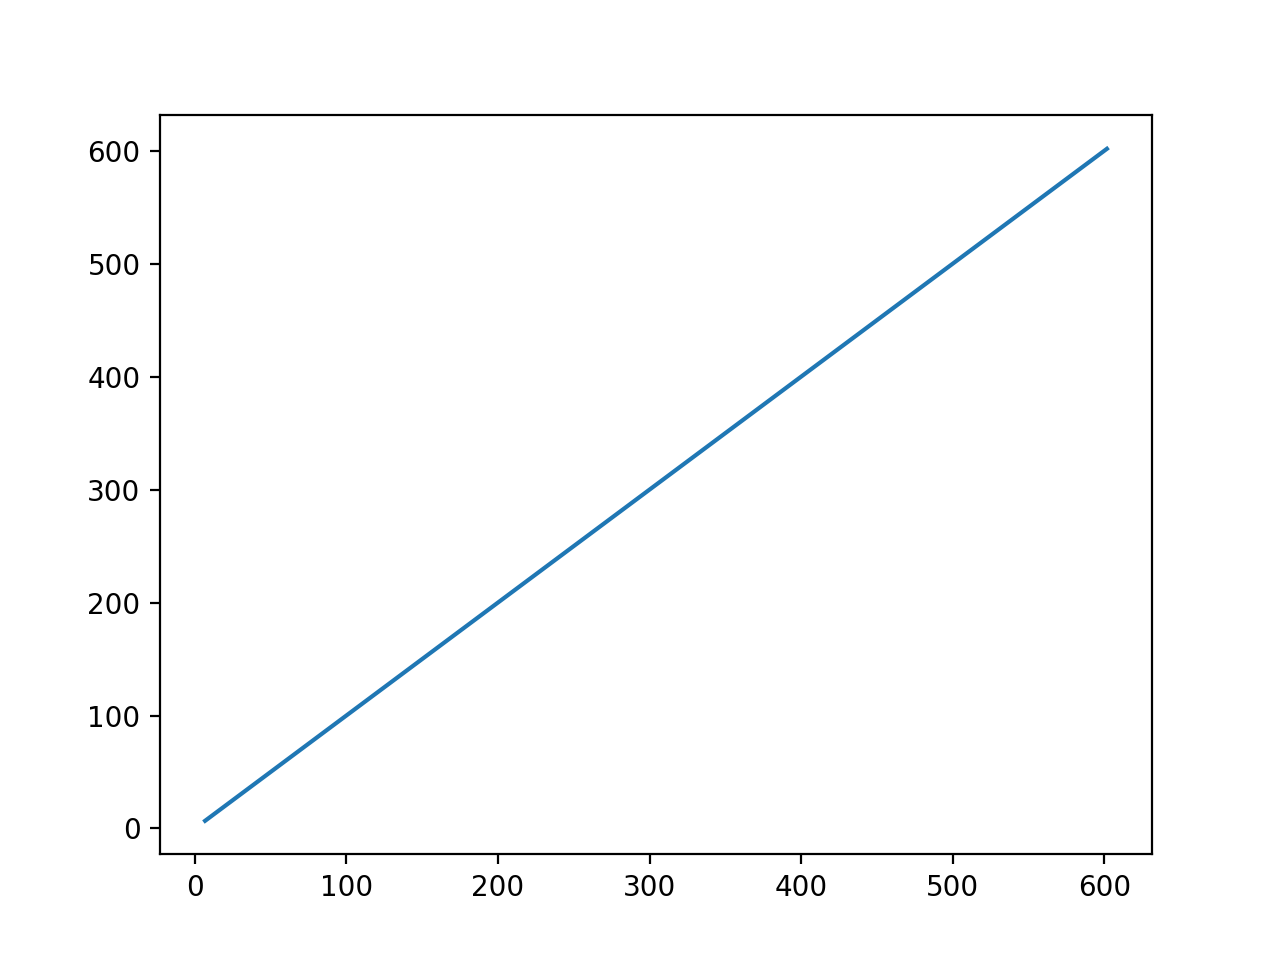

In [66]:
pl.figure()
pl.plot(df1['timestamp'], df2['timestamp'])

# Video

In [57]:
import cv2
import time
from IPython import display


In [58]:
vext='mp4'
vpath1 = '%s.%s' % (fn1.split('_metadata')[0], vext)
vpath2 = '%s.%s' % (fn2.split('_metadata')[0], vext)

print(vpath1)
print(vpath2)

/home/julianarhee/Videos/basler-pq/JB999_220705_144136/left_top.mp4
/home/julianarhee/Videos/basler-pq/JB999_220705_144136/right_top.mp4


In [59]:
def load_frames(fn):
    frames = []
    video = cv2.VideoCapture(fn)
    while True:
        read, frame= video.read()
        if not read:
            break
        frames.append(frame[:,:,0])
    frames = np.array(frames)
    return frames


In [60]:

def plot_frames(ax, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            #y = np.random.random(size=(100,1))
            ax.imshow(color)
            #ax.plot(x, y, color)
    fig.canvas.draw()

In [61]:
v1 = load_frames(vpath1)
v2 = load_frames(vpath2)
print("%s: %i frames" % (vpath1, len(v1)))
print("%s: %i frames" % (vpath2, len(v2)))

/home/julianarhee/Videos/basler-pq/JB999_220705_144136/left_top.mp4: 5944 frames
/home/julianarhee/Videos/basler-pq/JB999_220705_144136/right_top.mp4: 5944 frames


In [62]:
print(v1.size, v1.shape)

print(v2.size, v2.shape)

13694976000 (5944, 1200, 1920)
13694976000 (5944, 1200, 1920)


In [64]:
v1.dtype, v2.dtype

(dtype('uint8'), dtype('uint8'))

<IPython.core.display.Javascript object>


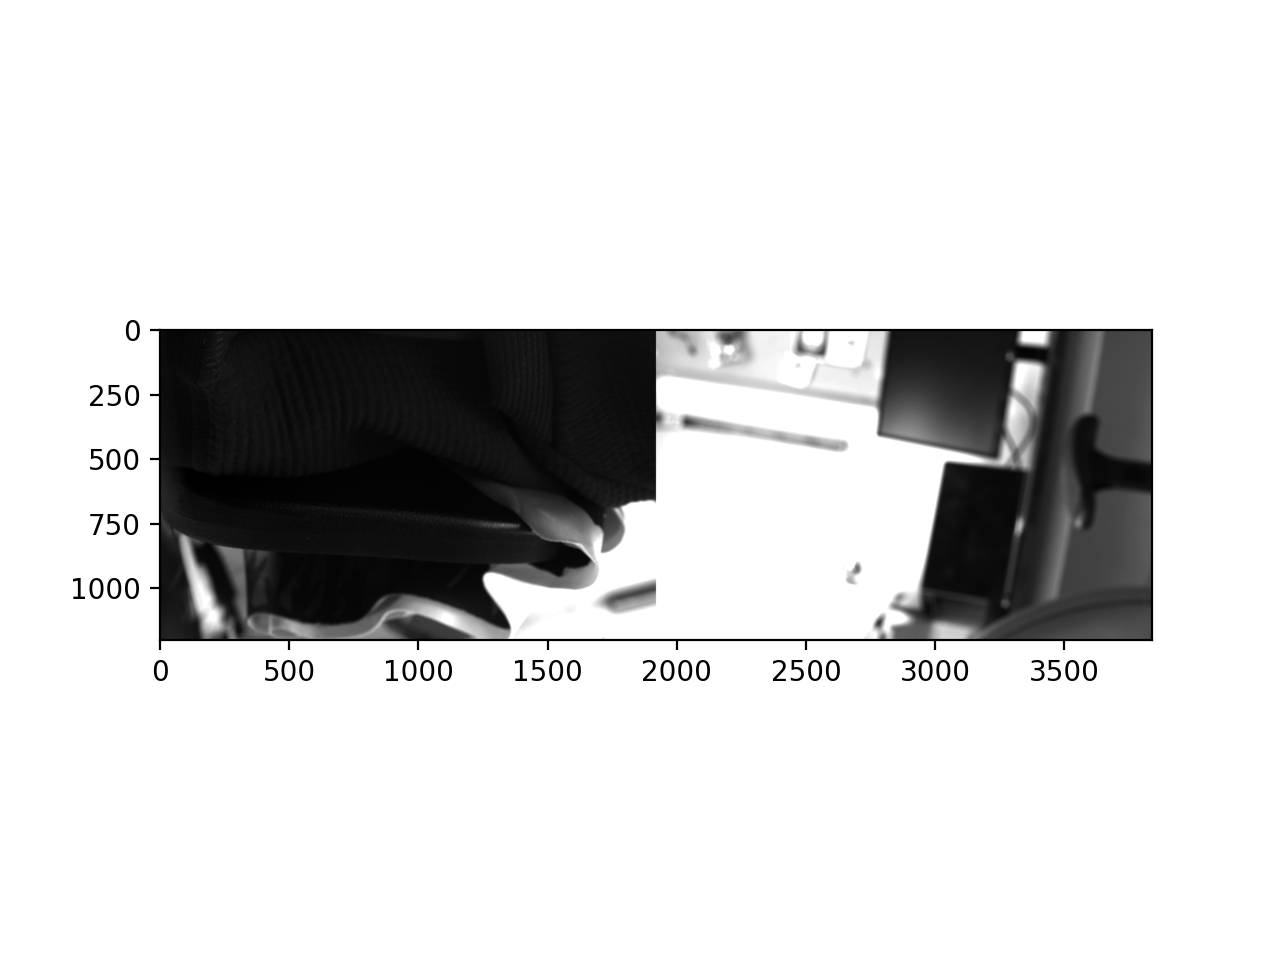

In [65]:
ix = 0
img = np.hstack((v1[ix,:,:], v2[ix,:,:]))
pl.figure()
pl.imshow(img, cmap='gray')

In [ ]:
fig, axes = pl.subplots(1,2)
#ix = -1
for ix in range(100):
    axes[0].imshow(v1[ix])
    axes[1].imshow(v2[ix])
    axes[0].set_title('frame %i' % ix)
#     pl.show()
#     time.sleep(1)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)
    

In [ ]:
fig,axes = pl.subplots(1,2)
for f in range(5):
    plot_frames(ax, ['b', 'r'])
    time.sleep(1)

In [26]:
v1.shape

(250, 1200, 1920, 3)

In [7]:
# metadata = (framecount, timestamp, arrival_time, sestime, cputime)
# (framecount, timestamp, sestime, cputime)

In [8]:
varnames = 'serial' #'serial' #['sestime', 'serial']
#df1 = pd.read_hdf(fn2) #, columns=varnames)
df1 = pd.DataFrame(np.array(h5py.File(fn1)[varnames]))
df1

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/julianarhee/Videos/basler-pq/JB999_220705_135620/right_top_metadata.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [17]:
df2 = pd.DataFrame(np.array(h5py.File(fn2)[varnames]))
df2

,0
0,22297042
1,22297042
2,22297042
3,22297042
4,22297042
5,22297042
6,22297042
7,22297042
8,22297042
9,22297042


In [18]:
diffs = df2.values - df1.values

<IPython.core.display.Javascript object>


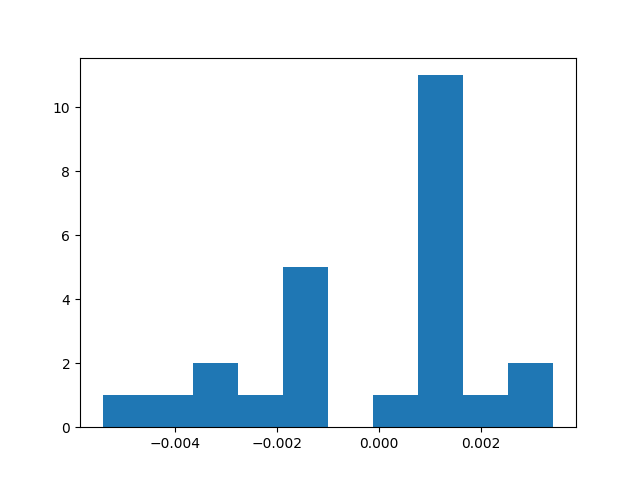

(array([ 1.,  1.,  2.,  1.,  5.,  0.,  1., 11.,  1.,  2.]),
 array([-0.00542641, -0.0045418 , -0.0036572 , -0.00277259, -0.00188799,
        -0.00100338, -0.00011878,  0.00076582,  0.00165043,  0.00253503,
         0.00341964]),
 <BarContainer object of 10 artists>)

In [15]:
pl.figure()
pl.hist(diffs)